In [1]:
import torch
from torch import nn
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

C:\Users\Pranav\Anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# Set up necessary file structure in test
import shutil
import os
import csv
def test_folders():
    # make folders
    all_path = 'GTSRB_Dataset/'
    test_path = 'GTSRB_Dataset/Test/'
    for i in range(43):
        path = os.path.join(test_path, str(i))
        os.mkdir(path)
    
    # assign images to folder based on csv
    with open(os.path.join(all_path, 'Test.csv')) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        i = 0
        for row in reader:
            if i != 0:
                dst_path = os.path.join(test_path, row[6])
                src_path = os.path.join(all_path, row[7])
                shutil.move(src_path, dst_path)
            i += 1
# test_folders()

In [3]:
train_dir = 'GTSRB_Dataset/Train'
test_dir = 'GTSRB_Dataset/Test'
transform = transforms.Compose([
    transforms.Resize([112, 112]),
    transforms.ToTensor()
])
train_set = datasets.ImageFolder(root=train_dir, transform=transform)
test_set = datasets.ImageFolder(root=test_dir, transform=transform)

# test_set = datasets.ImageFolder(root=test_dir, transform=transform)
num_labels = 43
# making map of pytorch class to actual class
idx_to_actual = dict()
labels = sorted([str(i) for i in range(num_labels)])
for i in range(len(labels)):
    idx_to_actual[i] = labels[i]
print(idx_to_actual)
# print(train_set[0])

{0: '0', 1: '1', 2: '10', 3: '11', 4: '12', 5: '13', 6: '14', 7: '15', 8: '16', 9: '17', 10: '18', 11: '19', 12: '2', 13: '20', 14: '21', 15: '22', 16: '23', 17: '24', 18: '25', 19: '26', 20: '27', 21: '28', 22: '29', 23: '3', 24: '30', 25: '31', 26: '32', 27: '33', 28: '34', 29: '35', 30: '36', 31: '37', 32: '38', 33: '39', 34: '4', 35: '40', 36: '41', 37: '42', 38: '5', 39: '6', 40: '7', 41: '8', 42: '9'}


In [4]:
from torch.utils.data.sampler import SubsetRandomSampler
ntotal = 39209
ntrain = int(0.9 * ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

In [5]:
batch_size = 200
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [8]:
# Code taken from Pytorch documentation
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

torch.Size([3, 112, 112])
4


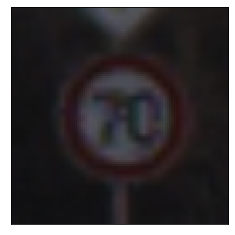

In [9]:
# print(train_set.classes)
for images, labels in train_loader:
#     print(images.shape, labels.shape)
    break
print(images[0].shape)
show(images[0])
# plt.savefig('./test.png')
print(idx_to_actual[labels[0].detach().item()])

In [10]:
class Classifier(nn.Module):
    def __init__(self, num_labels=43, p=0.5):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(4,4), stride=2),
            nn.MaxPool2d(kernel_size=(2,2), stride=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(4,4)),
            nn.MaxPool2d(kernel_size=(2,2), stride=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(4,4)),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(4,4), stride=2),
            nn.MaxPool2d(kernel_size=(2,2), stride=1),
            nn.ReLU(inplace=True),
            
            nn.Flatten(),
            nn.Dropout(p),
            nn.Linear(4410, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
            nn.Linear(1000, num_labels)
        )
    
    def forward(self, x):
        return self.layers(x)

In [11]:
model = Classifier()
print(images.shape)
output = model(images)
print(output.shape)

torch.Size([200, 3, 112, 112])
torch.Size([200, 43])


In [12]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=5):
    train_loss = []
    val_loss = []
    try:
        for epoch in tqdm(range(nepoch)):
            print('EPOCH %d'%epoch)
            model.train()
            total_loss = 0
            count = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model.forward(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                count += 1
            print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))
            train_loss.append(total_loss/count)
            
            model.eval()
            with torch.no_grad():
                total_loss = 0
                count = 0
                for inputs, labels in val_loader:
                    outputs = model.forward(inputs)
                    loss = criterion(outputs, labels)
                    total_loss += loss.item()
                    count += 1
                print('{:>12s} {:>7.5f}'.format('Val loss:', total_loss/count))
                val_loss.append(total_loss/count)
            print()
    except KeyboardInterrupt:
        print('Exiting from training early')
    return train_loss, val_loss

def test_network(model, test_loader, mode):
    correct = 0
    total = 0
    true, pred = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels  in test_loader:
            outputs = model.forward(inputs)
            predicted = torch.max(outputs, dim=1)[1] # get predicted class label for each test example.
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    print('%s accuracy: %0.3f' % (mode, acc))
    true = np.concatenate(true)
    pred = np.concatenate(pred)
    return acc, true, pred

In [13]:
# train the network
lr = 1e-3
model = Classifier()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

train_loss, val_loss = train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=15)
print(train_loss, val_loss)

EPOCH 0
 Train loss: 2.18392
   Val loss: 0.88093

EPOCH 1
 Train loss: 0.53640
   Val loss: 0.18533

EPOCH 2
 Train loss: 0.22610
   Val loss: 0.10360

EPOCH 3
 Train loss: 0.15686
   Val loss: 0.07752

EPOCH 4
 Train loss: 0.12199
   Val loss: 0.06622

EPOCH 5
 Train loss: 0.09569
   Val loss: 0.05225

EPOCH 6
 Train loss: 0.07971
   Val loss: 0.04018

EPOCH 7
 Train loss: 0.07106
   Val loss: 0.04375

EPOCH 8
 Train loss: 0.07193
   Val loss: 0.03782

EPOCH 9
 Train loss: 0.05723
   Val loss: 0.04095

EPOCH 10
 Train loss: 0.05623
   Val loss: 0.03874

EPOCH 11
 Train loss: 0.05455
   Val loss: 0.03320

EPOCH 12
 Train loss: 0.04423
   Val loss: 0.03601

EPOCH 13
 Train loss: 0.04424
   Val loss: 0.03356

EPOCH 14
 Train loss: 0.04188
   Val loss: 0.03053


[2.1839216351509094, 0.5363959364466748, 0.22609953308677944, 0.15685586193523837, 0.12198883419235547, 0.09568683370568995, 0.07971353025443978, 0.07105871937158754, 0.07193305686452968, 0.05723059336302307, 0.05622627669261337,

In [14]:
acc, true, pred = test_network(model, test_loader, 'Test')

Test accuracy: 96.136


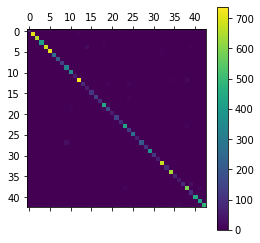

In [15]:
# contingency matrix
all_preds = pred
all_targets = true

# create contingency table
contingency = np.zeros((num_labels, num_labels))
for i in range(len(all_preds)):
  actual = all_targets[i]
  model_val = pred[i]
  contingency[model_val][actual] += 1

plt.matshow(contingency)
plt.colorbar()

In [13]:
# Save model state for future retrieval
def save_model():
    path = './GTSRB_Model.pth'
    if os.path.exists(path):
        os.remove(path)
    torch.save(model.state_dict(), path)
# save_model()

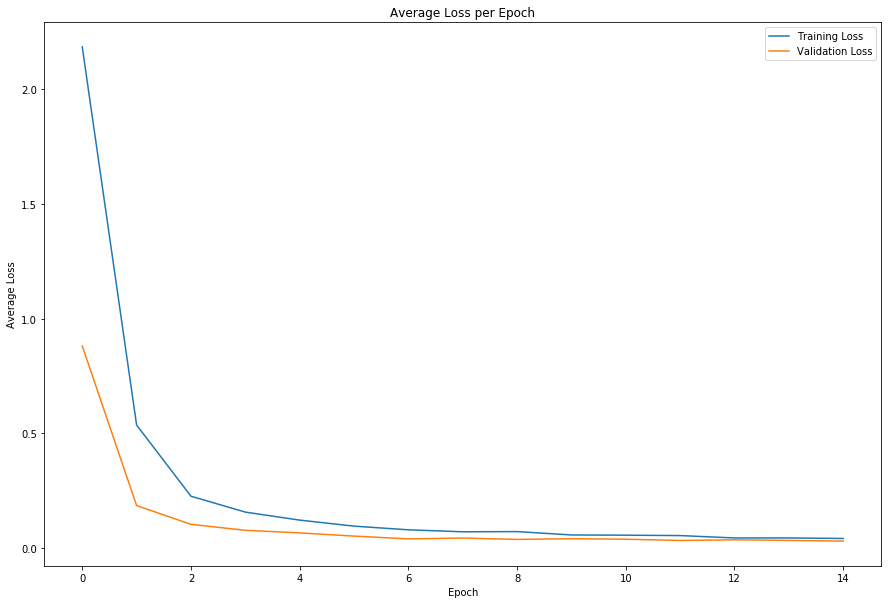

In [16]:
# Plot training and validation loss
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(train_loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
ax.set_title('Average Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Loss')
ax.legend()

In [11]:
# Load saved model
def load_model(model):
    path = './GTSRB_Model.pth'
    model.load_state_dict(torch.load(path))
model = Classifier()
load_model(model)
# acc, true, pred = test_network(model, test_loader, 'Test')

In [100]:
# Find and visualize 2 good examples and 2 bad examples
all_incorrect = []
all_incorrect_indices = []
all_correct = []
all_correct_indices = []
for i in range(len(true)):
    if true[i] != pred[i]:
        all_incorrect.append(test_set[i][0])
        all_incorrect_indices.append(i)
    else:
        all_correct.append(test_set[i][0])
        all_correct_indices.append(i)


12135
PREDICTED/ACTUAL Label:: 13


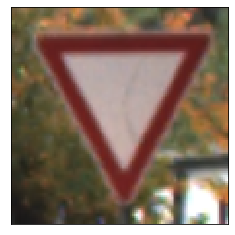

In [157]:
# total_incorrect = (true != pred).sum().item()
# if total_incorrect != len(all_incorrect):
#     print("NOT RECONCILED")

# print(total_incorrect)
# index = 19
# print("PREDICTED LABEL:: %s"%(idx_to_actual[pred[all_incorrect_indices[index]]]))
# print("ACTUAL LABEL:: %s"%(idx_to_actual[true[all_incorrect_indices[index]]]))
# show(all_incorrect[index])

total_correct = (true == pred).sum().item()
if total_correct != len(all_correct):
    print("NOT RECONCILED")

print(total_correct)
index = 2517
print("PREDICTED/ACTUAL Label:: %s"%(idx_to_actual[pred[all_correct_indices[index]]]))
show(all_correct[index])

# Bad examples: 3, 12 (could be because the brightness is higher than other 30 images), 6, 7, 17, 19 (blurry image) 
# Good examples: 1930, 2517 (has color of yellow but still gets the answer correct),  
# (good at recognizing different shape and brighter color of sign but seems to prioritize color over shape), 

In [99]:
incorrect = {}
correct = {}
for actual, predicted in zip(true, pred):
    if actual != predicted:
        if not actual in incorrect.keys():
            incorrect[actual] = 0
        incorrect[actual] += 1
    else:
        if not actual in correct.keys():
            correct[actual] = 0
        correct[actual] += 1
incorrect = {k: v for k, v in sorted(incorrect.items(), key=lambda item: item[1])}
correct = {k: v for k, v in sorted(correct.items(), key=lambda item: item[1])}
print("Incorrect:: " + str(incorrect))
print()
print("Correct:: " + str(correct))

Incorrect:: {0: 1, 6: 1, 13: 1, 8: 2, 17: 2, 29: 2, 30: 2, 27: 3, 28: 3, 33: 3, 5: 5, 25: 5, 31: 5, 12: 6, 15: 6, 22: 6, 32: 6, 2: 7, 3: 7, 21: 7, 35: 9, 9: 10, 1: 12, 23: 13, 4: 14, 40: 14, 37: 15, 36: 18, 24: 19, 34: 19, 39: 25, 41: 26, 16: 29, 18: 31, 19: 33, 38: 34, 14: 40, 10: 54}

Correct:: {36: 42, 14: 50, 31: 55, 0: 59, 11: 60, 20: 60, 26: 60, 37: 75, 35: 81, 22: 84, 33: 87, 17: 88, 13: 89, 15: 114, 28: 117, 30: 118, 16: 121, 39: 125, 24: 131, 21: 143, 19: 147, 8: 148, 27: 207, 7: 210, 25: 265, 6: 269, 10: 336, 9: 350, 29: 388, 3: 413, 41: 424, 40: 436, 23: 437, 18: 449, 42: 480, 38: 596, 34: 641, 2: 653, 4: 676, 32: 684, 1: 708, 5: 715, 12: 744}


# EXPERIMENT ONE

In [12]:
# Experiment 1: Gradient Visualization
class BackPropVisualization():
    def __init__(self, model):
        self.model = model
        self.model.eval()
    
    def get_gradients(self, image, target):
        image = image.clone().detach().requires_grad_(True)
        output = self.model(image)
        self.model.zero_grad()
        test = torch.zeros((1, num_labels))
        test[0][target] = 1
        output.backward(gradient=test)
        return image.grad.data.numpy()[0]

In [203]:
def find_indices(train_set):
    dic = dict()
    index = 0
    for i in range(num_labels):
        while test_set[index][1] != i:
            index += 1
        dic[i] = index
    return dic

In [204]:
# show(train_set[0][0])
dic = find_indices(train_set)

In [207]:
for key in dic.keys():
    print(str(key) + ": " + str(dic[key]))

0: 0
1: 60
2: 780
3: 1440
4: 1860
5: 2550
6: 3270
7: 3540
8: 3750
9: 3900
10: 4260
11: 4650
12: 4710
13: 5460
14: 5550
15: 5640
16: 5760
17: 5910
18: 6000
19: 6480
20: 6660
21: 6720
22: 6870
23: 6960
24: 7410
25: 7560
26: 7830
27: 7890
28: 8100
29: 8220
30: 8610
31: 8730
32: 8790
33: 9480
34: 9570
35: 10230
36: 10320
37: 10380
38: 10470
39: 11100
40: 11250
41: 11700
42: 12150


In [231]:
def format_image(grad):
    grad -= grad.min()
    grad /= grad.max()
    grad = grad.transpose(1, 2, 0)
    if np.max(grad) <= 1:
        grad = (grad*255).astype(np.uint8)
    return grad

In [232]:
# save the original images that are going to be used to create the gradient visualizations
def save_originals():
    for i in range(num_labels):
        show(test_set[dic[i]][0])
        path = os.path.join('./GTSRB Graphs/Experiment One/', 'orig' + str(idx_to_actual[i])+'.png')
        plt.savefig(path)

In [233]:
import torchvision
from PIL import Image
def show_gradient(index, save=False):
    image = test_set[index][0].reshape(1, 3, 112, 112)
    target = test_set[index][1]
    test = torchvision.models.alexnet(pretrained=True)
    BackPropVisual = BackPropVisualization(model)
    grad = BackPropVisual.get_gradients(image, target)
    grad = format_image(grad)
    im = Image.fromarray(grad)
    im.show()
    if save:
        path = os.path.join('./GTSRB Graphs/Experiment One/', str(idx_to_actual[target])+'.png')
        im.save(path)

In [234]:
def save_all():
    for i in range(num_labels):
        show_gradient(dic[i], save=True)

In [236]:
show_gradient(dic[0])

# EXPERIMENT TWO

In [17]:
class ClassifierDepth(nn.Module):
    def __init__(self, num_labels=43, p=0.5):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(4,4), stride=2),
            nn.MaxPool2d(kernel_size=(2,2), stride=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(4,4)),
            nn.MaxPool2d(kernel_size=(2,2), stride=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(4,4)),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(32,32), stride=2),
            nn.MaxPool2d(kernel_size=(2,2), stride=1),
            nn.ReLU(inplace=True),
            
            nn.Flatten(),
            nn.Dropout(p),
            nn.Linear(490, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(p),
            nn.Linear(1000, num_labels)
        )
    
    def forward(self, x):
        return self.layers(x)

In [18]:
# train the network
lr = 1e-3
model = ClassifierDepth()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

train_loss, val_loss = train_network(model, train_loader, val_loader, criterion, optimizer, nepoch=15)
print(train_loss, val_loss)

EPOCH 0
 Train loss: 2.50649
   Val loss: 1.06232

EPOCH 1
 Train loss: 0.88290
   Val loss: 0.36258

EPOCH 2
 Train loss: 0.47149
   Val loss: 0.19728

EPOCH 3
 Train loss: 0.31452
   Val loss: 0.12603

EPOCH 4
 Train loss: 0.23985
   Val loss: 0.07960

EPOCH 5
 Train loss: 0.19607
   Val loss: 0.06274

EPOCH 6
 Train loss: 0.17122
   Val loss: 0.05294

EPOCH 7
 Train loss: 0.14675
   Val loss: 0.05931

EPOCH 8
 Train loss: 0.12999
   Val loss: 0.05569

EPOCH 9
 Train loss: 0.11486
   Val loss: 0.04323

EPOCH 10
 Train loss: 0.10412
   Val loss: 0.03566

EPOCH 11
 Train loss: 0.09425
   Val loss: 0.04204

EPOCH 12
 Train loss: 0.09543
   Val loss: 0.03024

EPOCH 13
 Train loss: 0.08245
   Val loss: 0.03396

EPOCH 14
 Train loss: 0.08605
   Val loss: 0.03778


[2.506487321045439, 0.8829034339573424, 0.47149121357222734, 0.3145152154446995, 0.2398456908383612, 0.1960701526558332, 0.17121925032408225, 0.1467518680597429, 0.12998761169317752, 0.1148578222883118, 0.10411993487827521, 0.094

In [19]:
acc, true, pred = test_network(model, test_loader, 'Test')

Test accuracy: 95.067


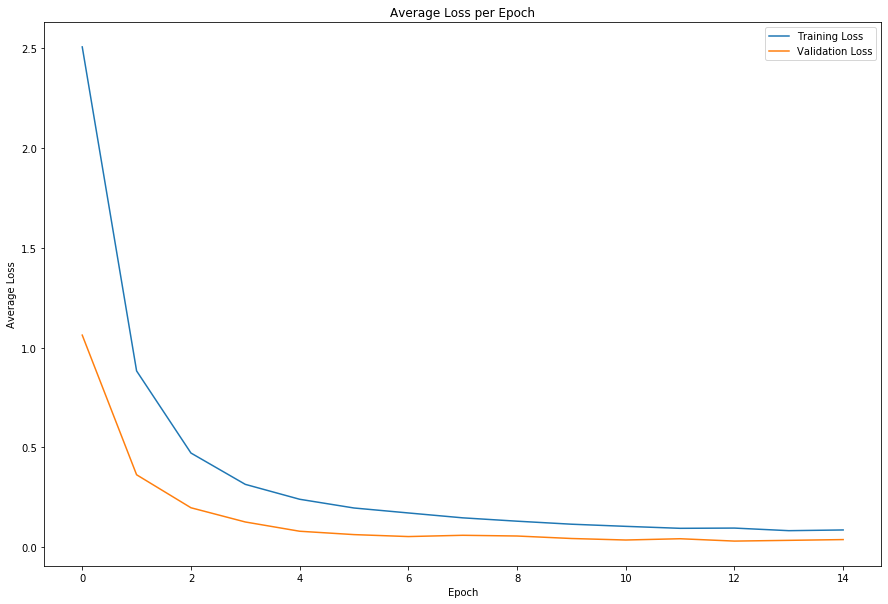

In [20]:
# Plot training and validation loss
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(train_loss, label='Training Loss')
ax.plot(val_loss, label='Validation Loss')
ax.set_title('Average Loss per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Loss')
ax.legend()